### Predict Sahel rainfall with LSTM/fc models - Optimize hyperparameters

In this project we work with **C**limate **I**ndex **C**ollection based on **Mo**del **D**ata (CICMoD) data set (https://github.com/MarcoLandtHayen/climate_index_collection). 

Here, we will relate to one of our earlier quickrun **LSTM/fc** models to **predict future** Sahel rainfall (lead times 1 month on CESM data) from current and past information (t<=0) of all input features including PREC_SAHEL and **months as additional input features**.

In particular, we will optimize selected hyperparameters:

- input length
- number of LSTM units (keep the number of layers fixed to two)
- number of fc units (keep the number of layers fixed to two)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from json import dump, load
from pathlib import Path

### Import additional functions:
from predict_sahel_rainfall.plot import bar_color
from predict_sahel_rainfall.preprocessing import prepare_inputs_and_target, get_target_months
from predict_sahel_rainfall.models import set_LSTM_fc

### Prepare inputs and targets

Load collection of climate indices directly from GitHub release.
Use the complete preprocessing pipeline function.

In [4]:
## Set common parameters (except ESN and lead time) for data preprocessing:

# Set url to csv file containing CICMoD indices from desired release:
data_url = (
    "https://github.com/MarcoLandtHayen/climate_index_collection/"
    "releases/download/v2023.03.29.1/climate_indices.csv"
)

# Select target index:
target_index = 'PREC_SAHEL'

# Select all input features:
input_features = [
    'AMO', 'ENSO_12', 'ENSO_3', 'ENSO_34', 'ENSO_4', 'NAO_PC', 'NAO_ST', 
    'NP', 'PDO_PC', 'PREC_SAHEL', 'SAM_PC', 'SAM_ZM', 'SAT_N_ALL', 'SAT_N_LAND',
    'SAT_N_OCEAN', 'SAT_S_ALL', 'SAT_S_LAND', 'SAT_S_OCEAN', 'SOI',
    'SSS_ENA', 'SSS_NA', 'SSS_SA', 'SSS_WNA', 'SST_ESIO', 'SST_HMDR',
    'SST_MED', 'SST_TNA', 'SST_TSA', 'SST_WSIO'
]

# # Select subset of input features:
# input_features = [
#     'PREC_SAHEL',
# ]

# Choose, whether to add months as one-hot encoded features:
add_months = True

# Choose, whether to normalize target index:
norm_target = True

# Specify amount of combined training and validation data relative to test data:
train_test_split = 0.9

# Specify relative amount of combined training and validation used for training:
train_val_split = 0.8

## Optionally choose to scale or normalize input features according to statistics from training data:
# 'no': Keep raw input features.
# 'scale_01': Scale input features with min/max scaling to [0,1].
# 'scale_11': Scale input features with min/max scaling to [-1,1].
# 'norm': Normalize input features, hence subtract mean and divide by std dev.
scale_norm = 'scale_11'

In [5]:
# Set parameters for LSTM/fc model:
LSTM_units = [10,20]
fc_units = [20,10]
fc_activation = 'sigmoid'
output_activation = 'linear'
LSTM_weight_init = 'glorot_uniform'
LSTM_recurrent_init = 'orthogonal'
LSTM_bias_init = 'zeros'
fc_weight_init = 'glorot_uniform'
fc_bias_init = 'zeros'
LSTM_weight_reg = None
LSTM_recurrent_reg = None
LSTM_bias_reg = None
fc_weight_reg = None
fc_bias_reg = None
learning_rate = 0.005
loss_function = 'mse'

In [6]:
# Set choice of ESMs:
ESMs = ['CESM']#, 'FOCI']

# Set choice of lead times:
lead_times = [1]#,3,6]

# Set number of runs per setting:
n_runs = 3

# Set number of training epochs:
n_epochs = 30

# Set batch size:
batch_size = 20

# Get number of input features, depending on whether or not months are addes as additional features:
if add_months:
    n_features = len(input_features) + 12
else:
    n_features = len(input_features)
    
# Check number of input channels:
print('Number of input features:',n_features)

Number of input features: 41


### Look for optimal input length

Keep all other parameters fixed - from quickrun experiments.
Allow additional 10 epochs (total: 30), to drive training into saturation.

In [5]:
## Specify input lengths to choose from:
input_lengths = [12, 18, 24, 30, 36]

## Initialize storages for loss curves and correlation, dimension (#input lengths, #ESMs, #lead times, #runs, #epochs+1).
## Need #epochs+1, since we want to store results for untrained model plus after each epoch.
train_loss_all = np.zeros((len(input_lengths),len(ESMs),len(lead_times),n_runs,n_epochs+1))
val_loss_all = np.zeros((len(input_lengths),len(ESMs),len(lead_times),n_runs,n_epochs+1))
test_loss_all = np.zeros((len(input_lengths),len(ESMs),len(lead_times),n_runs,n_epochs+1))
train_correl_all = np.zeros((len(input_lengths),len(ESMs),len(lead_times),n_runs,n_epochs+1))
val_correl_all = np.zeros((len(input_lengths),len(ESMs),len(lead_times),n_runs,n_epochs+1))
test_correl_all = np.zeros((len(input_lengths),len(ESMs),len(lead_times),n_runs,n_epochs+1))

## Loop over input lengths:
for i in range(len(input_lengths)):
    
    # Get current input length:
    input_length = input_lengths[i]
    
    # Print status:
    print('input length:',i+1,'of',len(input_lengths))

    ## Loop over ESMs:
    for m in range(len(ESMs)):

        # Get current ESM:
        ESM = ESMs[m]

        # Print status:
        print('  ESM:',m+1,'of',len(ESMs))

        ## Loop over lead times:
        for l in range(len(lead_times)):

            # Get current lead time:
            lead_time = lead_times[l]

            # Print status:
            print('    lead time:',l+1,'of',len(lead_times))

            # Prepare inputs and target for current ESM and lead time:
            (
                train_input,
                train_target,
                val_input,
                val_target,
                test_input,
                test_target,
                train_mean,
                train_std,
                train_min,
                train_max,
            ) = prepare_inputs_and_target(    
                data_url=data_url,
                ESM=ESM,
                target_index=target_index,
                input_features=input_features,
                add_months=add_months,
                norm_target=norm_target,
                lead_time=lead_time,
                input_length=input_length,
                train_test_split=train_test_split,
                train_val_split=train_val_split,
                scale_norm=scale_norm,
            )

            # Loop over desired number of training runs:
            for r in range(n_runs):

                # Print status:
                print('      run:',r+1,'of',n_runs)

                # Set up CNN/fc model:
                model = set_LSTM_fc(
                    input_length=input_length, 
                    n_features=n_features, 
                    LSTM_units=LSTM_units,
                    fc_units=fc_units, 
                    fc_activation=fc_activation,
                    output_activation=output_activation,
                    LSTM_weight_init=LSTM_weight_init,
                    LSTM_recurrent_init=LSTM_recurrent_init,
                    LSTM_bias_init=LSTM_bias_init,
                    fc_weight_init=fc_weight_init,
                    fc_bias_init=fc_bias_init,
                    LSTM_weight_reg=LSTM_weight_reg,
                    LSTM_recurrent_reg=LSTM_recurrent_reg,
                    LSTM_bias_reg=LSTM_bias_reg,
                    fc_weight_reg=fc_weight_reg,
                    fc_bias_reg=fc_bias_reg,
                    learning_rate=learning_rate, 
                    loss_function=loss_function
                )

                ### Train model: Epoch-by-epoch

                ## Store results for untrained model:

                # Get model predictions on training, validation and test data:
                train_pred = model.predict(train_input)
                val_pred = model.predict(val_input)
                test_pred = model.predict(test_input)

                # Compute mse of model predictions vs. true targets:
                train_loss = np.mean((train_target-train_pred)**2)
                val_loss = np.mean((val_target-val_pred)**2)
                test_loss = np.mean((test_target-test_pred)**2)

                # Compute correlation coefficient of model predictions vs. true targets:
                train_correl = np.corrcoef(np.stack([train_target[:,0],train_pred[:,0]]))[0,1]
                val_correl = np.corrcoef(np.stack([val_target[:,0],val_pred[:,0]]))[0,1]
                test_correl = np.corrcoef(np.stack([test_target[:,0],test_pred[:,0]]))[0,1]

                # Store results:
                train_loss_all[i,m,l,r,0] = train_loss
                val_loss_all[i,m,l,r,0] = val_loss
                test_loss_all[i,m,l,r,0] = test_loss
                train_correl_all[i,m,l,r,0] = train_correl
                val_correl_all[i,m,l,r,0] = val_correl
                test_correl_all[i,m,l,r,0] = test_correl          

                # Loop over epochs:
                for e in range(n_epochs):

                    # Train model for single epoch:
                    history = model.fit(train_input, train_target, epochs=1, batch_size=batch_size, shuffle=True, verbose=0)

                    ## Store results after current epoch:

                    # Get model predictions on training, validation and test data:
                    train_pred = model.predict(train_input)
                    val_pred = model.predict(val_input)
                    test_pred = model.predict(test_input)

                    # Compute mse of model predictions vs. true targets:
                    train_loss = np.mean((train_target-train_pred)**2)
                    val_loss = np.mean((val_target-val_pred)**2)
                    test_loss = np.mean((test_target-test_pred)**2)

                    # Compute correlation coefficient of model predictions vs. true targets:
                    train_correl = np.corrcoef(np.stack([train_target[:,0],train_pred[:,0]]))[0,1]
                    val_correl = np.corrcoef(np.stack([val_target[:,0],val_pred[:,0]]))[0,1]
                    test_correl = np.corrcoef(np.stack([test_target[:,0],test_pred[:,0]]))[0,1]

                    # Store results:
                    train_loss_all[i,m,l,r,e+1] = train_loss
                    val_loss_all[i,m,l,r,e+1] = val_loss
                    test_loss_all[i,m,l,r,e+1] = test_loss
                    train_correl_all[i,m,l,r,e+1] = train_correl
                    val_correl_all[i,m,l,r,e+1] = val_correl
                    test_correl_all[i,m,l,r,e+1] = test_correl          

input length: 1 of 5
  ESM: 1 of 1
    lead time: 1 of 1
      run: 1 of 3


2023-06-22 20:52:27.554562: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 20:52:27.806492: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


      run: 2 of 3
      run: 3 of 3
input length: 2 of 5
  ESM: 1 of 1
    lead time: 1 of 1
      run: 1 of 3
      run: 2 of 3
      run: 3 of 3
input length: 3 of 5
  ESM: 1 of 1
    lead time: 1 of 1
      run: 1 of 3
      run: 2 of 3
      run: 3 of 3
input length: 4 of 5
  ESM: 1 of 1
    lead time: 1 of 1
      run: 1 of 3
      run: 2 of 3
      run: 3 of 3
input length: 5 of 5
  ESM: 1 of 1
    lead time: 1 of 1
      run: 1 of 3
      run: 2 of 3
      run: 3 of 3


In [6]:
# ### Store results:

    
# ## LSTM/fc - multivariate - months as additional input features - optimize input length:

# # Specify model setup:
# setup = 'LSTM/fc - multivariate - with months - optimize input length'

# # Save loss and correlation results:
# np.save('../results/quickrun_LSTM_fc_multivariate_with_months_opt_inputlength_train_loss_all.npy', train_loss_all)
# np.save('../results/quickrun_LSTM_fc_multivariate_with_months_opt_inputlength_val_loss_all.npy', val_loss_all)
# np.save('../results/quickrun_LSTM_fc_multivariate_with_months_opt_inputlength_test_loss_all.npy', test_loss_all)
# np.save('../results/quickrun_LSTM_fc_multivariate_with_months_opt_inputlength_train_correl_all.npy', train_correl_all)
# np.save('../results/quickrun_LSTM_fc_multivariate_with_months_opt_inputlength_val_correl_all.npy', val_correl_all)
# np.save('../results/quickrun_LSTM_fc_multivariate_with_months_opt_inputlength_test_correl_all.npy', test_correl_all)

# # Store parameters:
# parameters = {
#     "setup": setup,
#     "data_url": data_url,
#     "target_index": target_index,
#     "input_features": input_features,
#     "add_months": add_months,
#     "norm_target": norm_target,
#     "input_lengths": input_lengths,
#     "train_test_split": train_test_split,
#     "train_val_split": train_val_split,
#     "train_val_split": train_val_split,
#     "scale_norm": scale_norm,    
#     "LSTM_units": LSTM_units,
#     "fc_units": fc_units,
#     "fc_activation": fc_activation,
#     "output_activation": output_activation,
#     "LSTM_weight_init": LSTM_weight_init,
#     "LSTM_recurrent_init": LSTM_recurrent_init,
#     "LSTM_bias_init": LSTM_bias_init,
#     "fc_weight_init": fc_weight_init,
#     "fc_bias_init": fc_bias_init,
#     "LSTM_weight_reg": LSTM_weight_reg,
#     "LSTM_recurrent_reg": LSTM_recurrent_reg,
#     "LSTM_bias_reg": LSTM_bias_reg,
#     "fc_weight_reg": fc_weight_reg,
#     "fc_bias_reg": fc_bias_reg,
#     "learning_rate": learning_rate,
#     "loss_function": loss_function,
#     "ESMs": ESMs,
#     "lead_times": lead_times,
#     "n_runs": n_runs,
#     "n_epochs": n_epochs,
#     "batch_size": batch_size,    
# }

# path_to_store_results = Path('../results')
# with open(path_to_store_results / "quickrun_LSTM_fc_multivariate_with_months_opt_inputlength_parameters.json", "w") as f:
#     dump(parameters, f)

In [7]:
# ### Reload results:

   
# ## LSTM/fc - multivariate - with months - optimize input length:

# # Load loss and correlation results:
# train_loss_all = np.load('../results/quickrun_LSTM_fc_multivariate_with_months_opt_inputlength_train_loss_all.npy')
# val_loss_all = np.load('../results/quickrun_LSTM_fc_multivariate_with_months_opt_inputlength_val_loss_all.npy')
# test_loss_all = np.load('../results/quickrun_LSTM_fc_multivariate_with_months_opt_inputlength_test_loss_all.npy',)
# train_correl_all = np.load('../results/quickrun_LSTM_fc_multivariate_with_months_opt_inputlength_train_correl_all.npy')
# val_correl_all = np.load('../results/quickrun_LSTM_fc_multivariate_with_months_opt_inputlength_val_correl_all.npy')
# test_correl_all = np.load('../results/quickrun_LSTM_fc_multivariate_with_months_opt_inputlength_test_correl_all.npy')

# # Load parameters:
# path_to_store_results = Path('../results')
# with open(path_to_store_results / 'quickrun_LSTM_fc_multivariate_with_months_opt_inputlength_parameters.json', 'r') as f:
#     parameters=load(f)

# input_lengths = parameters['input_lengths']
# ESMs = parameters['ESMs']
# lead_times = parameters['lead_times']
# n_runs = parameters['n_runs']
# n_epochs = parameters['n_epochs']

### Postprocessing

We now have loss ('mse') and correlation for complete training, validation and test data after each epoch (starting with untrained model as epoch 0).

Next, we aim to find the **minimum loss and maximum correlation on test data** for the **epoch with minimum validation loss**.
This search is done separately for each input length, ESM, lead time and model run.

In a second step, we compute the **mean loss and correlation on test data over all runs**, separately for each input length, ESM and lead time.

In [7]:
## Initialize storages for test loss (min) and correlation (max), where val loss takes its minimum,
## dimension (#input lengths, #ESMs, #lead times, #runs).
test_loss_min = np.zeros((len(input_lengths),len(ESMs),len(lead_times),n_runs))
test_correl_max = np.zeros((len(input_lengths),len(ESMs),len(lead_times),n_runs))

## Initializs storages for mean test loss and correlation, averaged over all training runs,
## dimension (#input lengths, #ESMs, #lead times).
test_loss_min_mean = np.zeros((len(input_lengths),len(ESMs),len(lead_times)))
test_correl_max_mean = np.zeros((len(input_lengths),len(ESMs),len(lead_times)))

## Loop over input lengths:
for i in range(len(input_lengths)):
    
    ## Loop over ESMs:
    for m in range(len(ESMs)):

        ## Loop over lead times:
        for l in range(len(lead_times)):

            # Loop over desired number of training runs:
            for r in range(n_runs):

                # Get epoch with minimum validation loss for current input length, ESM, lead time and training run:
                e_min = np.argmin(val_loss_all[i,m,l,r])

                # Store corresponding test loss and correlation:
                test_loss_min[i,m,l,r] = test_loss_all[i,m,l,r,e_min]
                test_correl_max[i,m,l,r] = test_correl_all[i,m,l,r,e_min]

            # Get mean test loss and correlation over all training runs, for current input length, ESM and lead time:
            test_loss_min_mean[i,m,l] = np.mean(test_loss_min[i,m,l])
            test_correl_max_mean[i,m,l] = np.mean(test_correl_max[i,m,l])

### Results: Multivariate LSTM/fc (with months as additional input features) - Optimize input length

In [15]:
test_loss_min_mean

array([[[0.89712752]],

       [[0.90237837]],

       [[0.90214142]],

       [[0.89710822]],

       [[0.89804992]]])

In [16]:
test_correl_max_mean

array([[[0.43137427]],

       [[0.42901022]],

       [[0.4297067 ]],

       [[0.43599171]],

       [[0.42990346]]])

### Discussion: LSTM / fc models - multivariate (with months as additional input features) - Optimize input length

Here, we tried to **predict future** Sahel rainfall (lead time 1 month) from current and past information (t<=0) of all **CESM** input features including PREC_SAHEL and months as additional input features with **LSTM/fc** models.

In particular, we tried to find the optimal input lengths from an array [12, 18, 24, 30, 36].
And the winner is: **30 months as input length**.

**Note:** Model results show only a weak dependency on the input length. Could also work with only 12 months, with almost similar performance.

### Optimize number of LSTM and fc units:

Keep all other parameters fixed - from quickrun experiments.
For input length, work with 30, as found to be optimal, above.
Allow additional 10 epochs (total: 30), to drive training into saturation.

In [8]:
## Specify input length:
input_length = 30

## Specify combinations for number of LSTM and fc units, to be considered in the optimization:
LSTM_units_settings = [[5,10],[10,20],[15,30]]
fc_units_settings = [[10,5],[20,10],[30,15]]


## Initialize storages for loss curves and correlation, 
## dimension (#ESMs, #lead times, #LSTM units settings, #fc units settings, #runs, #epochs+1).
## Need #epochs+1, since we want to store results for untrained model plus after each epoch.
train_loss_all = np.zeros((len(ESMs),len(lead_times),len(LSTM_units_settings),len(fc_units_settings),n_runs,n_epochs+1))
val_loss_all = np.zeros((len(ESMs),len(lead_times),len(LSTM_units_settings),len(fc_units_settings),n_runs,n_epochs+1))
test_loss_all = np.zeros((len(ESMs),len(lead_times),len(LSTM_units_settings),len(fc_units_settings),n_runs,n_epochs+1))
train_correl_all = np.zeros((len(ESMs),len(lead_times),len(LSTM_units_settings),len(fc_units_settings),n_runs,n_epochs+1))
val_correl_all = np.zeros((len(ESMs),len(lead_times),len(LSTM_units_settings),len(fc_units_settings),n_runs,n_epochs+1))
test_correl_all = np.zeros((len(ESMs),len(lead_times),len(LSTM_units_settings),len(fc_units_settings),n_runs,n_epochs+1))

## Loop over ESMs:
for m in range(len(ESMs)):

    # Get current ESM:
    ESM = ESMs[m]

    # Print status:
    print('ESM:',m+1,'of',len(ESMs))

    ## Loop over lead times:
    for l in range(len(lead_times)):

        # Get current lead time:
        lead_time = lead_times[l]

        # Print status:
        print('  lead time:',l+1,'of',len(lead_times))

        # Prepare inputs and target for current ESM and lead time:
        (
            train_input,
            train_target,
            val_input,
            val_target,
            test_input,
            test_target,
            train_mean,
            train_std,
            train_min,
            train_max,
        ) = prepare_inputs_and_target(    
            data_url=data_url,
            ESM=ESM,
            target_index=target_index,
            input_features=input_features,
            add_months=add_months,
            norm_target=norm_target,
            lead_time=lead_time,
            input_length=input_length,
            train_test_split=train_test_split,
            train_val_split=train_val_split,
            scale_norm=scale_norm,
        )

        ## Loop over LSTM units settings:
        for i in range(len(LSTM_units_settings)):

            # Get current LSTM units setting:
            LSTM_units = LSTM_units_settings[i]

            # Print status:
            print('    LSTM_units_setting:',i+1,'of',len(LSTM_units_settings))

            ## Loop over fc units settings:
            for j in range(len(fc_units_settings)):

                # Get current fc units setting:
                fc_units = fc_units_settings[j]

                # Print status:
                print('      fc_units_setting:',j+1,'of',len(fc_units_settings))
                
                # Loop over desired number of training runs:
                for r in range(n_runs):

                    # Print status:
                    print('        run:',r+1,'of',n_runs)

                    # Set up CNN/fc model:
                    model = set_LSTM_fc(
                        input_length=input_length, 
                        n_features=n_features, 
                        LSTM_units=LSTM_units,
                        fc_units=fc_units, 
                        fc_activation=fc_activation,
                        output_activation=output_activation,
                        LSTM_weight_init=LSTM_weight_init,
                        LSTM_recurrent_init=LSTM_recurrent_init,
                        LSTM_bias_init=LSTM_bias_init,
                        fc_weight_init=fc_weight_init,
                        fc_bias_init=fc_bias_init,
                        LSTM_weight_reg=LSTM_weight_reg,
                        LSTM_recurrent_reg=LSTM_recurrent_reg,
                        LSTM_bias_reg=LSTM_bias_reg,
                        fc_weight_reg=fc_weight_reg,
                        fc_bias_reg=fc_bias_reg,
                        learning_rate=learning_rate, 
                        loss_function=loss_function
                    )

                    ### Train model: Epoch-by-epoch

                    ## Store results for untrained model:

                    # Get model predictions on training, validation and test data:
                    train_pred = model.predict(train_input)
                    val_pred = model.predict(val_input)
                    test_pred = model.predict(test_input)

                    # Compute mse of model predictions vs. true targets:
                    train_loss = np.mean((train_target-train_pred)**2)
                    val_loss = np.mean((val_target-val_pred)**2)
                    test_loss = np.mean((test_target-test_pred)**2)

                    # Compute correlation coefficient of model predictions vs. true targets:
                    train_correl = np.corrcoef(np.stack([train_target[:,0],train_pred[:,0]]))[0,1]
                    val_correl = np.corrcoef(np.stack([val_target[:,0],val_pred[:,0]]))[0,1]
                    test_correl = np.corrcoef(np.stack([test_target[:,0],test_pred[:,0]]))[0,1]

                    # Store results:
                    train_loss_all[m,l,i,j,r,0] = train_loss
                    val_loss_all[m,l,i,j,r,0] = val_loss
                    test_loss_all[m,l,i,j,r,0] = test_loss
                    train_correl_all[m,l,i,j,r,0] = train_correl
                    val_correl_all[m,l,i,j,r,0] = val_correl
                    test_correl_all[m,l,i,j,r,0] = test_correl          

                    # Loop over epochs:
                    for e in range(n_epochs):

                        # Train model for single epoch:
                        history = model.fit(train_input, train_target, epochs=1, batch_size=batch_size, shuffle=True, verbose=0)

                        ## Store results after current epoch:

                        # Get model predictions on training, validation and test data:
                        train_pred = model.predict(train_input)
                        val_pred = model.predict(val_input)
                        test_pred = model.predict(test_input)

                        # Compute mse of model predictions vs. true targets:
                        train_loss = np.mean((train_target-train_pred)**2)
                        val_loss = np.mean((val_target-val_pred)**2)
                        test_loss = np.mean((test_target-test_pred)**2)

                        # Compute correlation coefficient of model predictions vs. true targets:
                        train_correl = np.corrcoef(np.stack([train_target[:,0],train_pred[:,0]]))[0,1]
                        val_correl = np.corrcoef(np.stack([val_target[:,0],val_pred[:,0]]))[0,1]
                        test_correl = np.corrcoef(np.stack([test_target[:,0],test_pred[:,0]]))[0,1]

                        # Store results:
                        train_loss_all[m,l,i,j,r,e+1] = train_loss
                        val_loss_all[m,l,i,j,r,e+1] = val_loss
                        test_loss_all[m,l,i,j,r,e+1] = test_loss
                        train_correl_all[m,l,i,j,r,e+1] = train_correl
                        val_correl_all[m,l,i,j,r,e+1] = val_correl
                        test_correl_all[m,l,i,j,r,e+1] = test_correl   

ESM: 1 of 1
  lead time: 1 of 1
    LSTM_units_setting: 1 of 3
      fc_units_setting: 1 of 3
        run: 1 of 3
        run: 2 of 3
        run: 3 of 3
      fc_units_setting: 2 of 3
        run: 1 of 3
        run: 2 of 3
        run: 3 of 3
      fc_units_setting: 3 of 3
        run: 1 of 3
        run: 2 of 3
        run: 3 of 3
    LSTM_units_setting: 2 of 3
      fc_units_setting: 1 of 3
        run: 1 of 3
        run: 2 of 3
        run: 3 of 3
      fc_units_setting: 2 of 3
        run: 1 of 3
        run: 2 of 3
        run: 3 of 3
      fc_units_setting: 3 of 3
        run: 1 of 3
        run: 2 of 3
        run: 3 of 3
    LSTM_units_setting: 3 of 3
      fc_units_setting: 1 of 3
        run: 1 of 3
        run: 2 of 3
        run: 3 of 3
      fc_units_setting: 2 of 3
        run: 1 of 3
        run: 2 of 3
        run: 3 of 3
      fc_units_setting: 3 of 3
        run: 1 of 3
        run: 2 of 3
        run: 3 of 3


In [9]:
# ### Store results:

    
# ## LSTM/fc - multivariate - months as additional input features - optimize LSTM and fc units:

# # Specify model setup:
# setup = 'LSTM/fc - multivariate - with months - optimize LSTM and fc units'

# # Save loss and correlation results:
# np.save('../results/quickrun_LSTM_fc_multivariate_with_months_opt_LSTMfc_units_train_loss_all.npy', train_loss_all)
# np.save('../results/quickrun_LSTM_fc_multivariate_with_months_opt_LSTMfc_units_val_loss_all.npy', val_loss_all)
# np.save('../results/quickrun_LSTM_fc_multivariate_with_months_opt_LSTMfc_units_test_loss_all.npy', test_loss_all)
# np.save('../results/quickrun_LSTM_fc_multivariate_with_months_opt_LSTMfc_units_train_correl_all.npy', train_correl_all)
# np.save('../results/quickrun_LSTM_fc_multivariate_with_months_opt_LSTMfc_units_val_correl_all.npy', val_correl_all)
# np.save('../results/quickrun_LSTM_fc_multivariate_with_months_opt_LSTMfc_units_test_correl_all.npy', test_correl_all)

# # Store parameters:
# parameters = {
#     "setup": setup,
#     "data_url": data_url,
#     "target_index": target_index,
#     "input_features": input_features,
#     "add_months": add_months,
#     "norm_target": norm_target,
#     "input_length": input_length,
#     "train_test_split": train_test_split,
#     "train_val_split": train_val_split,
#     "train_val_split": train_val_split,
#     "scale_norm": scale_norm,    
#     "LSTM_units_settings": LSTM_units_settings,
#     "fc_units_settings": fc_units_settings,
#     "fc_activation": fc_activation,
#     "output_activation": output_activation,
#     "LSTM_weight_init": LSTM_weight_init,
#     "LSTM_recurrent_init": LSTM_recurrent_init,
#     "LSTM_bias_init": LSTM_bias_init,
#     "fc_weight_init": fc_weight_init,
#     "fc_bias_init": fc_bias_init,
#     "LSTM_weight_reg": LSTM_weight_reg,
#     "LSTM_recurrent_reg": LSTM_recurrent_reg,
#     "LSTM_bias_reg": LSTM_bias_reg,
#     "fc_weight_reg": fc_weight_reg,
#     "fc_bias_reg": fc_bias_reg,
#     "learning_rate": learning_rate,
#     "loss_function": loss_function,
#     "ESMs": ESMs,
#     "lead_times": lead_times,
#     "n_runs": n_runs,
#     "n_epochs": n_epochs,
#     "batch_size": batch_size,    
# }

# path_to_store_results = Path('../results')
# with open(path_to_store_results / "quickrun_LSTM_fc_multivariate_with_months_opt_LSTMfc_units_parameters.json", "w") as f:
#     dump(parameters, f)

In [ ]:
# ### Reload results:

   
# ## LSTM/fc - multivariate - with months - optimize LSTM and fc units':

# # Load loss and correlation results:
# train_loss_all = np.load('../results/quickrun_LSTM_fc_multivariate_with_months_opt_LSTMfc_units_train_loss_all.npy')
# val_loss_all = np.load('../results/quickrun_LSTM_fc_multivariate_with_months_opt_LSTMfc_units_val_loss_all.npy')
# test_loss_all = np.load('../results/quickrun_LSTM_fc_multivariate_with_months_opt_LSTMfc_units_test_loss_all.npy',)
# train_correl_all = np.load('../results/quickrun_LSTM_fc_multivariate_with_months_opt_LSTMfc_units_train_correl_all.npy')
# val_correl_all = np.load('../results/quickrun_LSTM_fc_multivariate_with_months_opt_LSTMfc_units_val_correl_all.npy')
# test_correl_all = np.load('../results/quickrun_LSTM_fc_multivariate_with_months_opt_LSTMfc_units_test_correl_all.npy')

# # Load parameters:
# path_to_store_results = Path('../results')
# with open(path_to_store_results / 'quickrun_LSTM_fc_multivariate_with_months_opt_LSTMfc_units_parameters.json', 'r') as f:
#     parameters=load(f)

# ESMs = parameters['ESMs']
# lead_times = parameters['lead_times']
# LSTM_units_settings = parameters['LSTM_units_settings']
# fc_units_settings = parameters['fc_units_settings']
# n_runs = parameters['n_runs']
# n_epochs = parameters['n_epochs']

### Postprocessing

We now have loss ('mse') and correlation for complete training, validation and test data after each epoch (starting with untrained model as epoch 0).

Next, we aim to find the **minimum loss and maximum correlation on test data** for the **epoch with minimum validation loss**.
This search is done separately for each ESM, lead time, LSTM units setting, fc units setting and model run.

In a second step, we compute the **mean loss and correlation on test data over all runs**, separately for each ESM , lead time, LSTM units setting and fc units setting.

In [11]:
## Initialize storages for test loss (min) and correlation (max), where val loss takes its minimum,
## dimension (#ESMs, #lead times, #LSTM units settings, #fc units settings, #runs).
test_loss_min = np.zeros((len(ESMs),len(lead_times),len(LSTM_units_settings),len(fc_units_settings),n_runs))
test_correl_max = np.zeros((len(ESMs),len(lead_times),len(LSTM_units_settings),len(fc_units_settings),n_runs))

## Initializs storages for mean test loss and correlation, averaged over all training runs,
## dimension (#ESMs, #lead times, #LSTM units settings, #fc units settings).
test_loss_min_mean = np.zeros((len(ESMs),len(lead_times),len(LSTM_units_settings),len(fc_units_settings)))
test_correl_max_mean = np.zeros((len(ESMs),len(lead_times),len(LSTM_units_settings),len(fc_units_settings)))

## Loop over ESMs:
for m in range(len(ESMs)):

    ## Loop over lead times:
    for l in range(len(lead_times)):
        
        ## Loop over LSTM units settings:
        for i in range(len(LSTM_units_settings)):

            ## Loop over fc units settings:
            for j in range(len(fc_units_settings)):

                # Loop over desired number of training runs:
                for r in range(n_runs):

                    # Get epoch with minimum validation loss for current input length, ESM, lead time and training run:
                    e_min = np.argmin(val_loss_all[m,l,i,j,r])

                    # Store corresponding test loss and correlation:
                    test_loss_min[m,l,i,j,r] = test_loss_all[m,l,i,j,r,e_min]
                    test_correl_max[m,l,i,j,r] = test_correl_all[m,l,i,j,r,e_min]

                # Get mean test loss and correlation over all training runs, for current input length, ESM and lead time:
                test_loss_min_mean[m,l,i,j] = np.mean(test_loss_min[m,l,i,j])
                test_correl_max_mean[m,l,i,j] = np.mean(test_correl_max[m,l,i,j])

### Results: Multivariate LSTM/fc (with months as additional input features) - Optimize number of LSTM and fc units:

In [13]:
test_loss_min_mean[0,0]

array([[0.90612133, 0.90187901, 0.88459531],
       [0.89630444, 0.89526265, 0.90939876],
       [0.91666255, 0.90617237, 0.90452972]])

In [14]:
test_correl_max_mean[0,0]

array([[0.42273806, 0.42856439, 0.44713474],
       [0.43041591, 0.43590525, 0.4247378 ],
       [0.41222374, 0.4211525 , 0.42539671]])

In [17]:
test_loss_min[0,0,0,2]

array([0.89582771, 0.88638688, 0.87157133])

In [18]:
test_correl_max[0,0,0,2]

array([0.43260092, 0.44345661, 0.4653467 ])

### Discussion: Optimization of input length and number of LSTM and fc units - for LSTM / fc model

Find **input length = 30** as optimal.

With that choice, we find **[5, 10] LSTM units** with **[30, 15] fc units** to show best model performance.
At least, if we use all inputs from **CESM** data **with months as additional input feature** to predict Sahel rainfall with **lead time 1 month**.

**Note:** For this setting, **10 epochs** are sufficient. Don't need 30 epochs for driving training into saturation.

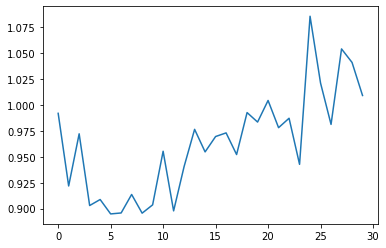

In [26]:
plt.plot(test_loss_all[0,0,0,2,0,1:])